In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

%run GeoModel.ipynb

In [2]:
def scaler(data, min_v, max_v):

    return min_v+(((data-data.min())*(max_v-min_v))/(data.max()-data.min()))


### Linear Regression

#### Tuning

In [4]:
from sklearn.linear_model import LinearRegression

# Load metadata
metadata = pd.read_csv('dataset_info.csv')
metadata.head()

,id,relationship,coeficients,trend,surface_level,spatial_autocorrelation,dataset_path,target_path,trend_path
0,0,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,high,dataset-TR_none_rel-linear-lvl_small-sac-high.csv,target-TR_none_rel-linear-lvl_small-sac-high.csv,trend_none.csv
1,1,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,low,dataset-TR_none_rel-linear-lvl_small-sac-low.csv,target-TR_none_rel-linear-lvl_small-sac-low.csv,trend_none.csv
2,2,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,none,dataset-TR_none_rel-linear-lvl_small-sac-none.csv,target-TR_none_rel-linear-lvl_small-sac-none.csv,trend_none.csv
3,3,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,high,dataset-TR_none_rel-polynom2-lvl_small-sac-hig...,target-TR_none_rel-polynom2-lvl_small-sac-high...,trend_none.csv
4,4,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,low,dataset-TR_none_rel-polynom2-lvl_small-sac-low...,target-TR_none_rel-polynom2-lvl_small-sac-low.csv,trend_none.csv


In [5]:
lr_param_to_test = {}
%run GeoModel.ipynb

#
for row in metadata.iloc[0:].iterrows():

    id_dataset = row[1]['id']

    features =  np.genfromtxt(f"data_features\\{row[1]['dataset_path']}", delimiter=',')
    labels = np.genfromtxt(f"data_labels\\{row[1]['target_path']}", delimiter=',')

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    c_train = X_train[:, -2:]
    c_test = X_test[:, -2:]

    X_train = X_train[:, :-2]
    X_test = X_test[:, :-2]

    GLR = GeographicalModel('LinearRegression', lr_param_to_test, 'fixed', 'gaussian', [200])
    single_bandwidth, best_bandwidth_arr = GLR.tune(c_train, X_train, y_train, -2, [5,10,15,20,25,30,35,40], step=3, limits=True, limits_ind=[20,120,20,120])

    single_bandwidth_arr = np.array([single_bandwidth])

    np.savetxt(f"tuningLR\\single_bandwidth\\single_bandwidth_id_{id_dataset}.csv", single_bandwidth_arr, delimiter=",")
    np.savetxt(f"tuningLR\\bandwidth\\bandwidth_id_{id_dataset}.csv", best_bandwidth_arr, delimiter=",")
    

#### BandwidthExplore

In [15]:
def interpolate_linear(coordinates, values, new_coordinates):
         
    # Create an empty array to store the interpolated values
    interpolated_values = np.zeros(len(new_coordinates))

    for i, new_coord in enumerate(new_coordinates):
        # Get the new x and y coordinates
        x_new, y_new = new_coord
        
        # Find the four closest points surrounding the new coordinates
        distances = np.sqrt((coordinates[:, 0] - x_new)**2 + (coordinates[:, 1] - y_new)**2)
        indices = np.argsort(distances)[:4]
        closest_coords = coordinates[indices]
        closest_values = values[indices]
        
        # Compute the weights based on inverse distance
        weights = 1 / distances[indices]
        weights /= weights.sum()
        
        # Interpolate the value for the new coordinates
        interpolated_values[i] = np.dot(weights, closest_values)

    return interpolated_values

In [126]:
id = 24
limits_ind = [20,120,20,120]


dataset_path = metadata.iloc[id]['dataset_path']
labels_path =  metadata.iloc[id]['target_path']

features =  np.genfromtxt(f"data_features\\{dataset_path}", delimiter=',')
labels = np.genfromtxt(f"data_labels\\{labels_path}", delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

c_train = X_train[:, -2:]

limits_indx = np.where((c_train[:,0] > limits_ind[0]) & (c_train[:,0] < limits_ind[1])
                            & (c_train[:,1] > limits_ind[2]) & (c_train[:,1] < limits_ind[3]))[0]

old_cord = c_train[limits_indx]

band_values =  np.genfromtxt(f"tuningLR\\bandwidth\\bandwidth_id_{id}.csv", delimiter=',')
band_values = band_values[limits_indx]

x_coord_linspace = np.arange(limits_ind[0], limits_ind[1], 1)
y_coord_linspace = np.arange(limits_ind[2], limits_ind[3], 1)

x_grid, y_grid = np.meshgrid(x_coord_linspace, y_coord_linspace)

new_coordinates = np.hstack((x_grid.flatten().reshape((-1,1)), y_grid.flatten().reshape((-1,1))))


In [127]:
band = interpolate_linear(old_cord, band_values, new_coordinates)

<ipython-input-15-9338abc21e21>:17: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1 / distances[indices]
<ipython-input-15-9338abc21e21>:18: RuntimeWarning: invalid value encountered in true_divide
  weights /= weights.sum()


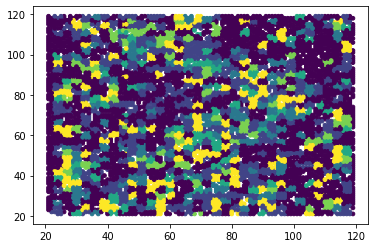

In [128]:
import matplotlib.pyplot as plt 

plt.scatter(x=old_cord[:,0],y=old_cord[:,1], c=band_values,s=14)

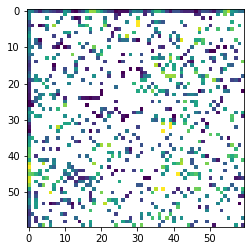

In [73]:
plt.imshow(band.reshape((60,60)))

In [62]:
x_coord_linspace

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74])

#### Testing

In [7]:
params = {}
from sklearn.linear_model import LinearRegression

In [8]:
%run GeoModel.ipynb

for row in tqdm(metadata.iloc[0:].iterrows(), total=len(metadata)):

    # load data
    id_dataset = row[1]['id']

    features =  np.genfromtxt(f"data_features\\{row[1]['dataset_path']}", delimiter=',')
    labels = np.genfromtxt(f"data_labels\\{row[1]['target_path']}", delimiter=',')

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    c_train = X_train[:, -2:]
    c_test = X_test[:, -2:]

    X_train_nocoord = X_train[:, :-2]
    X_test_nocoord = X_test[:, :-2]
    

    limits_ind = [20,120,20,120]
    limits_indx = np.where((c_test[:,0] > limits_ind[0]) & (c_test[:,0] < limits_ind[1])
                            & (c_test[:,1] > limits_ind[2]) & (c_test[:,1] < limits_ind[3]))[0]
    
    c_test_limits = c_test[limits_indx]

    c_test_limits_sc = scaler(c_test_limits, -1, 1)
    
    X_test_nocoord_limits = X_test_nocoord[limits_indx]
    X_test_limits = np.hstack((X_test_nocoord_limits, c_test_limits_sc))

    bandwidth = np.genfromtxt(f'tuningLR\\bandwidth\\bandwidth_id_{id_dataset}.csv', delimiter=',')
    # get single bandwidth
    single_bandwidth = np.genfromtxt(f'tuningLR\\single_bandwidth\\single_bandwidth_id_{id_dataset}.csv', delimiter=',')
    single_bandwidth = int(single_bandwidth)

    # train and fit global model
    # with coordinates
    LR_coord = LinearRegression(**params)
    LR_coord.fit(X_train, y_train)
    pred_LR_coord = LR_coord.predict(X_test_limits)
    
    # without coordinates
    LR_g = LinearRegression(**params)
    LR_g.fit(X_train_nocoord, y_train)
    pred_LR = LR_g.predict(X_test_nocoord_limits)

    GLR = GeographicalModel('LinearRegression', params, 'fixed', 'gaussian', [200])
    # local model
    # GRF
    GLR_pred = GLR.predict(single_bandwidth, 'fixed', 'linear', c_train, X_train_nocoord, y_train, c_test_limits, X_test_nocoord_limits, -2)

    # MSGRF
    MSGLR_pred = GLR.predict(bandwidth, 'fixed', 'linear', c_train, X_train_nocoord, y_train, c_test_limits, X_test_nocoord_limits, -2)

    # save results to csv 
    np.savetxt(f"testingLR\\LR_coord\\LR_coord_id_{id_dataset}.csv", pred_LR_coord, delimiter=",")
    np.savetxt(f"testingLR\\LR\\LR_id_{id_dataset}.csv", pred_LR, delimiter=",")
    np.savetxt(f"testingLR\\GLR\\GLR_id_{id_dataset}.csv", GLR_pred, delimiter=",")
    np.savetxt(f"testingLR\\MSGLR\\MSGLR_id_{id_dataset}.csv", MSGLR_pred, delimiter=",")